In [117]:
import pandas as pd
from pathlib import Path

# Analysis of trends in the BLS Telework data, tabulated from CPS.


The telework data is a series of monthly releases of telework data with consistent table names and formating. That makes it easy to read and combine them.

The data was first published for October 2022, and the most recent data is from January 2024. Breakdowns are provided by industry, and measures include (any) telework as well as typical hours teleworked, and the share teleworking full time / all hours.

[BLS source](https://www.bls.gov/cps/telework.htm)

# Helper functions


In [118]:
def write_data_to_excel(data, out_path):
    """
    Writes data to an Excel spreadsheet with separate sheets for each category.

    Args:
        data (pandas.DataFrame): The data to be written. It is assumed to have a 'Category' column.
        out_path (str): The path to the output Excel file.
    """

    def sheet_name_formatter(x): return x.replace(' ', '').replace('-', '')

    with pd.ExcelWriter(out_path) as writer:
        for category, group_data in data.groupby('Category'):
            sheet_name = sheet_name_formatter(category)
            group_data.unstack('year_mo').T.to_excel(writer, sheet_name)

In [119]:
def load_tables(input_folder, **xls_kwargs):
    storage = {}
    
    # get excel files in passed folder
    bls_files = Path(
        input_folder).glob('*.xlsx')
    
    # loop through them and load the file - note that skiprows arg will be different for different subtables
    for f in bls_files:
        # print(f)
        temp = pd.read_excel(f, **xls_kwargs)
        
        # use file name, encoding year and month, as the key
        storage[f.parts[-1]] = temp
        
    # contatenate and drop the useless oid
    output = pd.concat(
        storage, names=['year_mo', 'oid']).reset_index(1, drop=True)
    return output

In [120]:
# the BLS files use white space to denote summary levels. Useful to pull this out before stripping later so we
# don't end up summing incongruous categories

def sumlevel_guesser(s):
    stripped = s.lstrip()
    indent = len(s) - len(stripped)
    return f'{indent:02d}'

# Load data

In [121]:
# First, load the first sheet in all the workbooks - which has TOC data, to see which is available for each release

input_folder = '/Users/aolsen/Box/Modeling and Surveys/Miscellany/Contextual/Post Covid Behavior/bls_telework'
bls_telework_toc = load_tables(
    input_folder, sheet_name='List of tables', skiprows=3)


bls_telework_toc.groupby(['year_mo', 'Unnamed: 1']).size().unstack(1)

Unnamed: 1,Average weekly hours of work and percent of hours teleworked by telework status and selected characteristics,"Average weekly hours of work and percent of hours teleworked by telework status, usual full- and part-time status, occupation, industry, and class of worker","Number and percent of persons at work who teleworked or worked at home for pay, February 2020 (before the COVID-19 pandemic) and current month","Percent distribution of persons at work by telework status and selected characteristics, February 2020 (before the COVID-19 pandemic) and current month",Persons at work by telework status and selected characteristics,"Persons at work by telework status and selected characteristics, February 2020 (before the COVID-19 pandemic) and current month","Persons at work by telework status, usual full- and part-time status, occupation, industry, and class of worker",Persons who teleworked or worked at home for pay and average weekly hours teleworked by selected characteristics,"Persons who teleworked or worked at home for pay and average weekly hours teleworked by usual full- and part-time status, occupation, industry, and class of worker",Persons who teleworked or worked at home for pay by average weekly hours teleworked and selected characteristics,"Persons who teleworked or worked at home for pay by average weekly hours teleworked, full- or part-time status, occupation, industry, and class of worker"
year_mo,,,,,,,,,,,
telework-tables-2022-10.xlsx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
telework-tables-2022-11.xlsx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
telework-tables-2022-12.xlsx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
telework-tables-2023-01.xlsx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
telework-tables-2023-02.xlsx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
telework-tables-2023-03.xlsx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
telework-tables-2023-04.xlsx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
telework-tables-2023-05.xlsx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
telework-tables-2023-06.xlsx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [122]:
# There are subtle formating differences for some of the tables, but mostly 
# well behaved so we put procsesing in a function

def clean_and_transform_bls_telework_data(variable, categories, **xls_kwargs):
    """Loads, cleans, and transforms BLS telework data.

    Args:
        variable (str): Name of the variable to extract.
        categories (list): List of category names.
        **xls_kwargs: Additional keyword arguments to pass to `load_tables`.
                       This includes:
                       - sheet_name (str): Name of the sheet to load.
                       - skiprows (int): Number of rows to skip on load.
                       - Other keyword arguments supported by `load_tables`.

    Returns:
        pd.Series: Cleaned and transformed data series.
    """

    # Load data
    bls_telework = load_tables(
        input_folder=input_folder, **xls_kwargs)

    # Clean index
    bls_telework.index = bls_telework.index.str.replace(
        'telework-tables-', '').str.replace('.xlsx', '')

    # Extract category rows
    bls_telework.loc[bls_telework.Characteristic.isin(
        categories), 'Category'] = bls_telework.loc[bls_telework.Characteristic.isin(categories), 'Characteristic']

    # Forward-fill categories
    bls_telework.Category = bls_telework.Category.fillna(method='ffill')

    # Clean category names
    bls_telework.Category = bls_telework.Category.str.replace(
        '\d$', '').str.replace('\xa0', ' ')

    # Drop rows with missing values for the target variable
    bls_telework = bls_telework[bls_telework[variable].notna()]

    # Add summary levels
    bls_telework['sumlev'] = bls_telework.Characteristic.apply(
        sumlevel_guesser)

    # Clean characteristic string
    bls_telework.Characteristic = bls_telework.Characteristic.str.lstrip()

    # Create a series with desired index levels
    bls_telework_var = bls_telework.set_index(
        ['sumlev', 'Category', 'Characteristic'], append=True)[variable]

    # Enforce numeric values
    bls_telework_var = pd.to_numeric(bls_telework_var, errors='coerce')

    return bls_telework_var

# Table 2 - high level share teleworking by industry, occup, etc

In [123]:
# these are category stubs preceding detailed categories - we filter on these, get the relevant
# indices, move to a new column and forward fill so we have a handy classification

categories = ['Class of worker3', 'Industry',
              'Occupation', 'Usual full- and part-time status']


variable = 'Persons who did not telework or work at home for pay.1'

In [124]:
bls_telework_t2_var = clean_and_transform_bls_telework_data(
    sheet_name='Table 2', skiprows=4, variable=variable, categories=categories)
bls_telework_t2_var.head().reset_index()

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58538/3410045125.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  'telework-tables-', '').str.replace('.xlsx', '')
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58538/3410045125.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  bls_telework.Category = bls_telework.Category.str.replace(


,year_mo,sumlev,Category,Characteristic,Persons who did not telework or work at home for pay.1
0,2022-10,00,Usual full- and part-time status,"Total, 16 years and over",82.1
1,2022-10,04,Usual full- and part-time status,Full-time workers,80.9
2,2022-10,04,Usual full- and part-time status,Part-time workers,88.5
3,2022-10,00,Occupation,"Management, professional, and related occupations",69.0
4,2022-10,04,Occupation,"Management, business, and financial operations...",63.5


In [125]:
# out_path = '/Users/aolsen/Box/Modeling and Surveys/Miscellany/Contextual/Post Covid Behavior/bls_telework/processed/telework_bls.xlsx'
# write_data_to_excel(bls_telework_t2_var, out_path)

# Table 6 - Percent distribution of persons who teleworked or worked at home for pay

In [126]:
# this one is focused on the telecommuting public - what is the share who telecommute ALL hours?

categories = ['Class of worker2', 'Industry',
              'Occupation', 'Usual full- and part-time status']

# variable

variable = 'Teleworked all hours.1'
bls_telework_t6_var = clean_and_transform_bls_telework_data(
    sheet_name='Table 6', skiprows=3, variable=variable, categories=categories)
bls_telework_t6_var.head().reset_index()

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58538/3410045125.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  'telework-tables-', '').str.replace('.xlsx', '')
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_58538/3410045125.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  bls_telework.Category = bls_telework.Category.str.replace(


,year_mo,sumlev,Category,Characteristic,Teleworked all hours.1
0,2022-10,00,Usual full- and part-time status,"Total, 16 years and over",54.5
1,2022-10,04,Usual full- and part-time status,Full-time workers,53.0
2,2022-10,04,Usual full- and part-time status,Part-time workers,67.5
3,2022-10,00,Occupation,"Management, professional, and related occupations",53.0
4,2022-10,04,Occupation,"Management, business, and financial operations...",53.6


In [127]:
# out_path = '/Users/aolsen/Box/Modeling and Surveys/Miscellany/Contextual/Post Covid Behavior/bls_telework/processed/telework_bls_fulltime.xlsx'
# write_data_to_excel(bls_telework_t6_var, out_path)

# Combine teleworker shares and full time share among those
Of telecommunters, what share is full time tele?

In [128]:
# merge t2 and t6

tele_combo = pd.concat([bls_telework_t6_var,
                        bls_telework_t2_var],
                       axis=1,
                       keys=[
                       'of_telewkrs_pct_fulltime', 'no_tele']
                       )

In [129]:
# add a few extra vars
tele_combo['yes_tele'] = 100-tele_combo.no_tele
tele_combo['pct_full_time_tele'] = tele_combo['yes_tele'] * \
    tele_combo['of_telewkrs_pct_fulltime'] / 100.

## plotting

<AxesSubplot: xlabel='year_mo'>

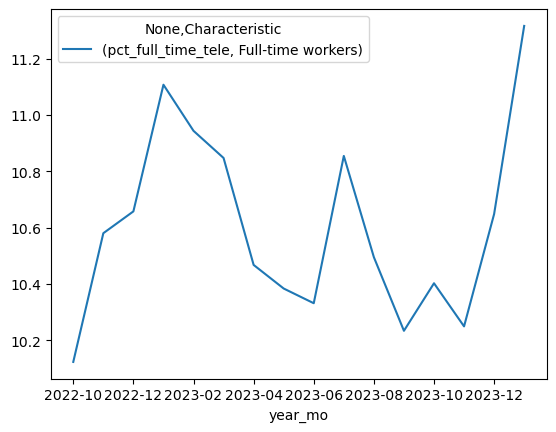

In [130]:
tele_combo.loc(0)[:,:,:,'Full-time workers'].pct_full_time_tele.reset_index([1,2]).unstack(1).plot()

Text(0.5, 1.0, 'Estimate of full time telecommuters by select industries\nSource: BLS CPS telework tabulations, multiple releases')

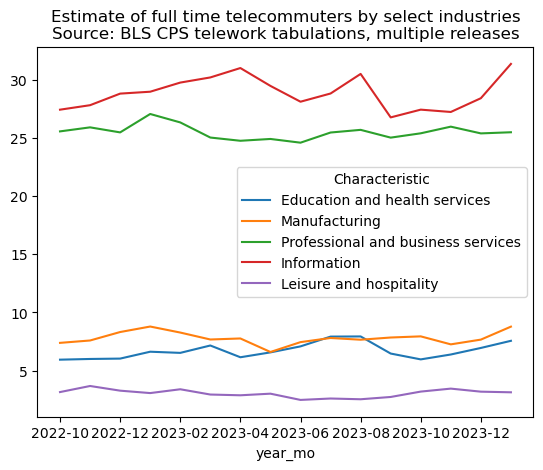

In [131]:
select_indus_groups = ['Education and health services','Manufacturing','Professional and business services','Information','Leisure and hospitality']
ax = tele_combo.loc(0)[:, :, :, select_indus_groups].reset_index([1,2]).pct_full_time_tele.unstack().plot()
ax.set_title('Estimate of full time telecommuters by select industries\nSource: BLS CPS telework tabulations, multiple releases')

Text(0.5, 1.0, 'Estimate of full time telecommuters by select occupations\nSource: BLS CPS telework tabulations, multiple releases')

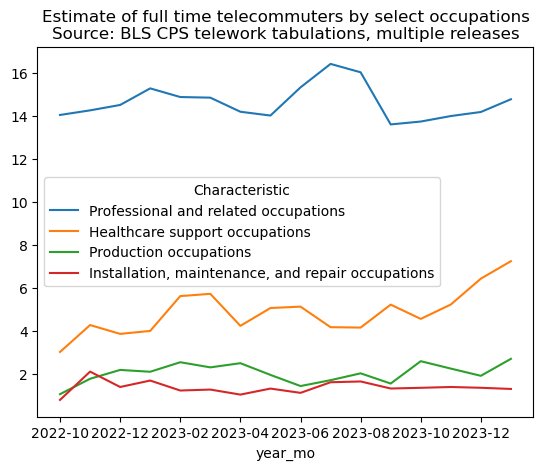

In [132]:
select_occup_groups = ['Professional and related occupations','Healthcare support occupations','Production occupations','Installation, maintenance, and repair occupations']
ax = tele_combo.loc(0)[:, :, :, select_occup_groups].reset_index([1,2]).pct_full_time_tele.unstack().plot()
ax.set_title('Estimate of full time telecommuters by select occupations\nSource: BLS CPS telework tabulations, multiple releases')

In [133]:
tele_combo.pct_full_time_tele.loc[:,'00'].unstack([1,2])

Category       Usual full- and part-time status  \
Characteristic         Total, 16 years and over   
year_mo                                           
2022-10                                  9.7555   
2022-11                                 10.0825   
2022-12                                 10.3170   
2023-01                                 10.6894   
2023-02                                 10.5800   
2023-03                                 10.5300   
2023-04                                 10.0640   
2023-05                                 10.0170   
2023-06                                 10.1080   
2023-07                                 10.5868   
2023-08                                 10.2765   
2023-09                                 10.0188   
2023-10                                 10.1376   
2023-11                                 10.0450   
2023-12                                 10.4901   
2024-01                                 11.1065   

Category                                              Occupation  \
Characteristic Management, professional, and related occupations   
year_mo                                                            
2022-10                                                  16.4300   
2022-11                                                  16.5157   
2022-12                                                  16.8432   
2023-01                                                  17.5230   
2023-02                                                  17.0859   
2023-03                                                  17.1127   
2023-04                                                  16.6216   
2023-05                                                  16.4220   
2023-06                                                  16.8777   
2023-07                                                  17.9520   
2023-08                                                  17.7152   
2023-09                                                  16.2288   
2023-10                                                  16.4119   
2023-11                                                  16.4256   
2023-12                                                  16.8820   
2024-01                                                  17.6148   

Category                                                         \
Characteristic Service occupations Sales and office occupations   
year_mo                                                           
2022-10                     1.8502                      11.6982   
2022-11                     1.8009                      12.6063   
2022-12                     1.7696                      12.9168   
2023-01                     2.1862                      12.4644   
2023-02                     2.4723                      12.7544   
2023-03                     2.4453                      12.6880   
2023-04                     1.9034                      11.9201   
2023-05                     2.3218                      12.0190   
2023-06                     2.2533                      12.2180   
2023-07                     2.2716                      12.7624   
2023-08                     2.1016                      11.5420   
2023-09                     2.2920                      12.4915   
2023-10                     2.2534                      12.3165   
2023-11                     2.1800                      12.0312   
2023-12                     2.7002                      12.9954   
2024-01                     3.0108                      13.5207   

Category                                                                     \
Characteristic Natural resources, construction, and maintenance occupations   
year_mo                                                                       
2022-10                                                    0.5355             
2022-11                                                    0.9900             
2022-12                                                    0.7002   